In [2]:
#%matplotlib inline
from pylab import *
from acceptance import acceptance_sim

# Assume a maximum altitude of the UHECR of 10 km and a 10 degree view angle cutoff, 
# so for a given zenith angle th_z, the radius of the area to be considered is 10 km * (tan(thz+10 deg) - tan(10 deg))

thz = np.arange(0., 85., 2.5)

rad = 10.*(np.tan((thz+9.9)*np.pi/180.) - np.tan(thz*np.pi/180.))
for k in range(0,len(thz)):
    th_val = thz[k] + 2.5
    dA_0 = 2. * np.pi * np.sin(th_val*np.pi/180.) * np.cos(th_val*np.pi/180.) * np.pi * rad[k]**2
    print('%1.1f\t%1.1f\t%1.1f'%(thz[k], rad[k], dA_0))


SyntaxError: unexpected EOF while parsing (detector_array.py, line 57)

In [ ]:
rcParams['font.size'] = 16
# 10^17 eV
th_z     = np.array([0.,   2.5,  5.0,  7.5,  10.,  12.5, 15.,  20.,  30.,  40., 50., 52.5, 53., 54., 54.5, 55., 60.])
rad      = np.array([1.7,  1.8,  1.8,  1.8,  1.9,  1.9,  2.0,  2.1,  2.6,  3.5, 5.3, 6.1, 7.1, 7.1, 7.1, 7.1, 10.])
eff_1e4  = np.array([210., 196., 182., 191., 181., 185., 168., 173., 102., 65., 61., 49., 36., 34., 32., 0.,  0.])

dA_0 = 2. * np.pi * np.cos(th_z*np.pi/180.) * np.pi * rad**2

#plot(th_z, dA_0)
figure(1)
plot(np.cos(th_z*pi/180.), dA_0*eff_1e4*1.e-4, '.-')
ylabel(r'$d<A\Omega>/d\cos\theta$, km$^2$ sr')
xlabel(r'$\cos(\theta_z)$, deg')
figure(2)
plot(th_z, np.sin(th_z*np.pi/180.)*dA_0*eff_1e4*1.e-4, '.-')
xlabel(r'$\theta_z$, deg')
ylabel(r'$d<A\Omega>/d\theta$, km$^2$ sr deg$^{-1}$')

figure(3)


In [ ]:
# Voltage SNR of 10 matches
# Need to get right filter response in there.
# Overestimating SNR
detector_mode = 'prototype_2018'
e_array = np.arange(16.5, 19.0, 0.1)
acc = np.zeros(len(e_array))
cc=-1
thz_list_of_arrays = []
xmax_list_of_arrays = []
view_ang_list_of_arrays = []
for en in e_array:
    cc+=1
    rad = (10**(en-17.))**0.4
    A_0 = np.pi**2 * rad**2
    eff, thz_array, xmax_array, view_array = acceptance_sim(radius_km = rad,
                         num_particles = 10000,
                         zenith_angle_deg = None,
                         log10_energy = en,
                         SNR_thresh = 5,
                         N_trig = 4,
                         trig_pol = 'hpol',
                         detector_altitude_km = 3.87553,
                         detector_mode = detector_mode
                        )

    acc[cc] = eff*A_0
    thz_list_of_arrays.append(thz_array)
    xmax_list_of_arrays.append(xmax_array)
    view_ang_list_of_arrays.append(view_array)
    print('%1.1f %1.1f, %1.2e %1.2e %1.2e %1.2e'%(en, rad, eff, A_0, eff*A_0, acc[cc]))

In [ ]:
print(acc.shape)
print(e_array)
semilogy(e_array, 0.75*acc, lw=2)
xticks(np.arange(16.5, 19.1, 0.5))
xlabel('$\log_{10}(E/\mathrm{eV})$')
ylabel('Acceptance, km$^2$ sr')
grid(True, which='both', alpha=0.5)
xlim(16.5, 19)
y1, y2 = ylim()
y1 = 0.01
print(np.floor(np.log10(np.min(acc[acc>0.]))))
#ylim(10.**np.floor(np.log10(np.min(acc[acc>0.]))), y2)
#ylim(y1,y2)
tight_layout()
savefig('Acceptance_%s.pdf'%detector_mode, bbox_inches='tight')

In [ ]:
def flux(energy_array_eV):
    # parameterization from Auger ICRC 2017
    J0 = 2.7513872e-19 # km^-2 sr^-1 yr^-1 eV^-1
    E_ankle = 5.08e18  # eV
    E_s = 3.9e19       # eV
    gam_1 = 3.293
    gam_2 = 2.53
    dgam  = 2.5
    flux = np.ones(len(energy_array_eV))
    cut_1 = energy_array_eV<=E_ankle
    cut_2 = energy_array_eV>E_ankle

    flux[cut_1]=J0*(energy_array_eV[cut_1]/E_ankle)**-gam_1
    flux[cut_2]=J0*(energy_array_eV[cut_2]/E_ankle)**-gam_2 * (1.+(E_ankle/E_s)**dgam)/((1.+(energy_array_eV[cut_2]/E_s)**dgam))
    return flux

#print(10**e_array)
flx = flux(10**e_array)

semilogy(e_array, flx*10**e_array)
T_live = 24./(365.25*24.)

figure()
plot(e_array, flx * 10**e_array * acc * np.log(10.)*0.1 * T_live, drawstyle='steps')

xlabel('$\log_{10}(E/\mathrm{eV})$')
ylabel('Num. Events / day / bin')
grid(True, which='both', alpha=0.5)
xlim(16.5, 18.5)
y1, y2 = ylim()
ylim(0., y2)
tight_layout()
savefig('Energy_Distrib_%s.pdf'%detector_mode, bbox_inches='tight')

d_log_10_E = 0.1
figure()
semilogy(e_array, ( np.sum(flx * 10**e_array * acc) - np.cumsum(flx * 10**e_array * acc) )*np.log(10.)* d_log_10_E * T_live, drawstyle='steps')

print(max(np.cumsum(flx * 10**e_array * acc)*np.log(10.)* d_log_10_E * T_live))
print(sum(flx * 10**e_array * acc * np.log(10.)*0.1 * T_live))

In [3]:
wh, b = np.histogram(xmax_list_of_arrays[0], bins = np.arange(0., 10., 0.05))
wh = wh*0.
cc=0
for k in range(20):
    weight = flx[k] * 10**e_array[k] * acc[k] * np.log(10.)*0.1 * T_live
    h, b = np.histogram(xmax_list_of_arrays[k], bins = np.arange(0., 10., 0.05))
    wh += h*weight
    plot(b[1:], h*weight, lw = (cc+1)*0.2, label="%2.1f"%e_array[k])
    #print(e_array[k])
    cc+=1
legend(loc=[1.1,0.], fontsize=8)
figure()
plot(b[1:], wh/np.sum(wh), drawstyle='steps')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,10)
xticks(np.arange(0.,10.,2))
grid(True, which='both')
xlabel('Xmax altitude (km)')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('Xmax_altitude_distrib_%s.pdf'%detector_mode, bbox_inches='tight')

NameError: name 'xmax_list_of_arrays' is not defined

In [4]:
wh, b = np.histogram(view_ang_list_of_arrays[0], bins = np.arange(0., 4.0, 0.2))
wh = wh*0.
cc=0
for k in range(20):
    weight = flx[k] * 10**e_array[k] * acc[k] * np.log(10.)*0.1 * T_live
    h, b = np.histogram(view_ang_list_of_arrays[k], bins = np.arange(0., 4.0, 0.2))
    wh += h*weight
    plot(b[1:], h*weight, lw = (cc+1)*0.2, label="%2.1f"%e_array[k])
    #print(e_array[k])
    cc+=1
legend(loc=[1.1,0.], fontsize=8)
figure()
plot(b[1:], wh/np.sum(wh), drawstyle='steps')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,10)
xticks(np.arange(0.,10.,2))
grid(True, which='both')
xlabel('View Angle (deg)')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('ViewAngle_distrib_%s.pdf'%detector_mode, bbox_inches='tight')

NameError: name 'view_ang_list_of_arrays' is not defined

In [5]:
wh, b = np.histogram(thz_list_of_arrays[0], bins = np.arange(-10., 91., 5.))
wh = wh*0.
cc=0
for k in range(len(thz_list_of_arrays)):
    weight = flx[k] * 10**e_array[k] * acc[k] * np.log(10.)*0.1 * T_live
    h, b = np.histogram(thz_list_of_arrays[k], bins = np.arange(-10., 91., 5.))
    wh += h*weight
    plot(b[1:], h*weight, lw = (cc+1)*0.2, label="%2.1f"%e_array[k])
    #print(e_array[k])
    cc+=1
legend(loc=[1.1,0.], fontsize=8)
figure()
plot(b[1:], wh/np.sum(wh), drawstyle='steps')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both')
xlabel('Zenith Angle, deg')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('Zenith_angle_distrib_%s.pdf'%detector_mode, bbox_inches='tight')

NameError: name 'thz_list_of_arrays' is not defined

In [6]:
for i in range(7,25,3):
    plt.plot( thz_list_of_arrays[i],xmax_list_of_arrays[i],'.', label="%2.1f"%e_array[i],
                marker='.',markersize=0.5*(i+3), alpha=3./(i))
    
    cut1 = np.where(thz_list_of_arrays[i] > 69.0)[0]
    cut2 = np.where(thz_list_of_arrays[i] < 71.0)[0]
    cut = np.logical_and(cut1,cut2)
    print(e_array[i], xmax_list_of_arrays[i][cut])
plt.legend(fontsize=12)
plt.xlabel("Zenith Angle (deg)")
plt.ylabel(r"$\chi_{max}$ Altitude (km)")

NameError: name 'thz_list_of_arrays' is not defined

Text(0, 0.5, 'CDF')

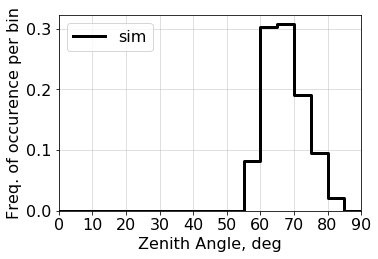

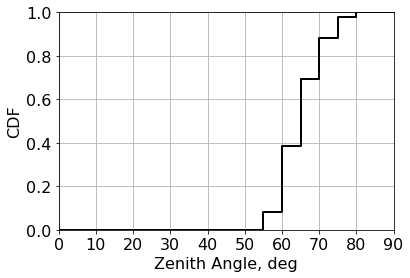

In [52]:
figure()
plot(b[1:], wh/np.sum(wh), 'k-', lw=3, drawstyle='steps', label='sim')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both', alpha=0.5)
xlabel('Zenith Angle, deg')
ylabel('Freq. of occurence per bin')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('zen_angle_distrib_%s.pdf'%detector_mode, bbox_inches='tight')

#CR_vals = 90.-np.array([61.67, 47.93, 40.26, 63.76, 42.43, 63.21, 40.03, 44.30, 54.86, 48.83])
#NC_vals = 90. - np.array([20.2, 33.8])

#CR_vals = np.array([28., 41., 49., 26., 48., 26., 49., 45., 35., 41.])
#NC_vals = np.array([55., 68.])

#bar(CR_vals, 0.12*np.ones(len(CR_vals)), align='center', color='green', alpha=1.0,  label='CR')
#bar(NC_vals, 0.12*np.ones(len(NC_vals)), align='center', color='orange', alpha=1.0, label='NC')
legend()

#measured_vals = np.concatenate([CR_vals, NC_vals])

'''%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''

figure()
#u = (np.cumsum(np.ones(len(CR_vals)))-1)/float(len(CR_vals)-1)
#plot(np.sort(CR_vals),u, 'gx-')

#u = (np.cumsum(np.ones(len(measured_vals)))-1)/float(len(measured_vals)-1)
#plot(np.sort(measured_vals),u, 'o-', color='orange', lw=3)

plot(b[1:], np.cumsum(wh/np.sum(wh)), 'k-', drawstyle='steps', lw=2)
ylim(0., 1.)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both')
xlabel('Zenith Angle, deg')
ylabel('CDF')

#from scipy import stats
#tats.ks_2samp(CR_vals, rvs4)

In [53]:
# Voltage SNR of 10 matches
# Need to get right filter response in there.
# Overestimating SNR
def acceptance(num_particles, SNR_thresh, N_trig, detector_mode='prototype_2019'):
    e_array = np.arange(17.0, 19.0, 0.1)
    acc = np.zeros(len(e_array))
    cc=-1
    thz_list_of_arrays = []
    for en in e_array:
        cc+=1
        rad = (10**(en-17.))**0.4
        A_0 = np.pi**2 * rad**2
        eff, thz_array, xmax_array, view_array = acceptance_sim(radius_km = rad,
                             num_particles = num_particles,
                             zenith_angle_deg = None,
                             log10_energy = en,
                             SNR_thresh = SNR_thresh,
                             N_trig = N_trig,
                             trig_pol = 'hpol',
                             detector_altitude_km = 3.87553,
                             detector_mode = 'prototype_2019'
                            )
        acc[cc] = eff*A_0
        print('%1.1f %1.1f, %1.2e %1.2e %1.2e %1.2e'%(en, rad, eff, A_0, eff*A_0, acc[cc]))
    return en, rad, eff, A_0, acc

In [54]:
SNR_array = np.arange(5.0, 12, 1.0)
list_acc = []
for SNR_thresh in SNR_array:
    en, rad, eff, A_0, acc = acceptance(10000, 
                                        SNR_thresh, 
                                        4, 
                                        detector_mode='prototype_2019')
    list_acc.append(acc)

17.0 1.0, 0.00e+00 9.87e+00 0.00e+00 0.00e+00
17.1 1.1, 0.00e+00 1.19e+01 0.00e+00 0.00e+00
17.2 1.2, 1.00e-04 1.43e+01 1.43e-03 1.43e-03
17.3 1.3, 3.60e-03 1.72e+01 6.17e-02 6.17e-02
17.4 1.4, 8.30e-03 2.06e+01 1.71e-01 1.71e-01
17.5 1.6, 1.29e-02 2.48e+01 3.20e-01 3.20e-01
17.6 1.7, 1.47e-02 2.98e+01 4.38e-01 4.38e-01
17.7 1.9, 1.74e-02 3.58e+01 6.24e-01 6.24e-01
17.8 2.1, 1.95e-02 4.31e+01 8.40e-01 8.40e-01
17.9 2.3, 1.73e-02 5.18e+01 8.96e-01 8.96e-01
18.0 2.5, 1.85e-02 6.23e+01 1.15e+00 1.15e+00
18.1 2.8, 1.81e-02 7.49e+01 1.36e+00 1.36e+00
18.2 3.0, 1.58e-02 9.00e+01 1.42e+00 1.42e+00
18.3 3.3, 1.23e-02 1.08e+02 1.33e+00 1.33e+00
18.4 3.6, 1.21e-02 1.30e+02 1.57e+00 1.57e+00
18.5 4.0, 1.24e-02 1.56e+02 1.94e+00 1.94e+00
18.6 4.4, 9.10e-03 1.88e+02 1.71e+00 1.71e+00
18.7 4.8, 1.13e-02 2.26e+02 2.55e+00 2.55e+00
18.8 5.2, 7.70e-03 2.72e+02 2.09e+00 2.09e+00
18.9 5.8, 7.00e-03 3.27e+02 2.29e+00 2.29e+00
17.0 1.0, 0.00e+00 9.87e+00 0.00e+00 0.00e+00
17.1 1.1, 0.00e+00 1.19e+01 0.00e+

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bot

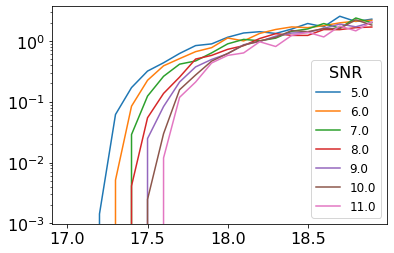

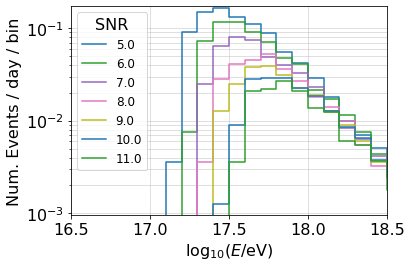

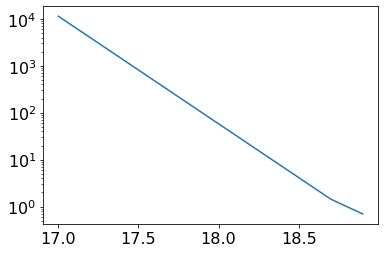

In [55]:
e_array = np.arange(17.0, 19.0, 0.1)
nevents_day_list = np.zeros(len(SNR_array))
for i,SNR_thresh in enumerate(SNR_array):
    figure(1)
    semilogy(e_array, list_acc[i], label=SNR_thresh)
    legend(title="SNR", fontsize=12)

figure(2)
flx = flux(10**e_array)
figure(3)
for i,SNR_thresh in enumerate(SNR_array):
    #print(10**e_array)


    semilogy(e_array, flx*10**e_array)
    T_live = 24./(365.25*24.)

    figure(2)
    plot(e_array, flx * 10**e_array * list_acc[i] * np.log(10.)*0.1 * T_live,
         label=SNR_thresh,drawstyle='steps')

    xlabel('$\log_{10}(E/\mathrm{eV})$')
    ylabel('Num. Events / day / bin')
    grid(True, which='both', alpha=0.5)
    xlim(16.5, 18.5)
    y1, y2 = ylim()
    ylim(0., y2)
    tight_layout()
    legend(title='SNR', fontsize=12)
    
    nevents_day = np.sum(flx * 10**e_array * list_acc[i] * np.log(10.)*0.1 * T_live)
    nevents_day_list[i] = nevents_day

Text(0, 0.5, 'Events per day')

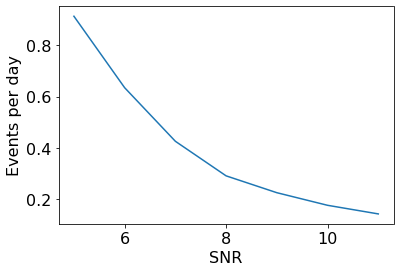

In [56]:
plot(SNR_array, nevents_day_list)
xlabel("SNR")
ylabel("Events per day")